In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the environment variable to prevent OpenMP library conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Define the Neural Network Architecture (PINN) ---

class PINN_Net(nn.Module):
    """
    A simple fully connected neural network (FNN) for the PINN solution u(x, y).
    Input: (x, y) coordinates (2 features)
    Output: u (1 feature)
    """
    def __init__(self, layers):
        super(PINN_Net, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 2):
            self.net.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f'activation_{i}', nn.Tanh())
        self.net.add_module('linear_last', nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.net(x)

# --- 2. Define the PINN Loss Function Components ---

class PINN_Solver:
    def __init__(self, model, source_term=-10.0):
        self.model = model.to(device)
        self.source_term = torch.tensor(source_term, dtype=torch.float32).to(device)
        self.criterion = nn.MSELoss()

    def pde_loss(self, xy_pde):
        """Calculates the residual of the Poisson equation: L_PDE = || d^2u/dx^2 + d^2u/dy^2 - f ||^2"""
        # Ensure gradients are computed for the input
        xy_pde.requires_grad_(True)

        # Get the predicted solution u
        u = self.model(xy_pde)

        # Compute first derivatives: du/dx and du/dy
        # grad_u is a tensor of shape (N, 2) where N is the number of points
        grad_u = torch.autograd.grad(
            u, xy_pde,
            grad_outputs=torch.ones_like(u), # Required when u is a vector (multiple points) to perform a proper summation for the gradient.
            create_graph=True, # This instructs PyTorch to build a new computational graph for this gradient calculation. This allows us to take the second derivative 
            retain_graph=True # Keeps the graph structure intact after this calculation, 
        )[0]
        
        # Isolate du/dx (gradient with respect to the first input, x) and du/dy
        u_x = grad_u[:, 0]
        u_y = grad_u[:, 1]
        
        # Compute second derivatives: d^2u/dx^2 and d^2u/dy^2
        # d^2u/dx^2
        u_xx = torch.autograd.grad(
            u_x, xy_pde,
            grad_outputs=torch.ones_like(u_x), 
            create_graph=True, # We still keep this in order to compute derivative for loss function, then update weight and bias.
            retain_graph=True 
        )[0][:, 0].unsqueeze(1) # Take derivative w.r.t x (column 0)
        
        # d^2u/dy^2
        u_yy = torch.autograd.grad(
            u_y, xy_pde,
            grad_outputs=torch.ones_like(u_y),
            create_graph=True,
            retain_graph=True
        )[0][:, 1].unsqueeze(1) # Take derivative w.r.t y (column 1)
        
        # Calculate the PDE residual: u_xx + u_yy - f = 0
        pde_residual = u_xx + u_yy - self.source_term
        
        return self.criterion(pde_residual, torch.zeros_like(pde_residual))

    def dirichlet_loss(self, xy_dirichlet):
        """Calculates the loss for Dirichlet boundary conditions: L_D = || u - 1 ||^2"""
        u_pred = self.model(xy_dirichlet)
        # Target value for all Dirichlet boundaries is 1
        u_target = torch.ones_like(u_pred) 
        return self.criterion(u_pred, u_target)

    def neumann_loss(self, xy_neumann):
        """Calculates the loss for Neumann boundary conditions: L_N = || du/dn - 0 ||^2"""
        # Ensure gradients are computed for the input
        xy_neumann.requires_grad_(True)
        
        # Get the predicted solution u
        u = self.model(xy_neumann)

        # Compute first derivatives: du/dx and du/dy
        grad_u = torch.autograd.grad(
            u, xy_neumann,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        
        # The Neumann boundaries are Left (x=0) and Right (x=1).
        # The normal derivative is du/dn = du/dx on the right boundary and du/dn = -du/dx on the left boundary.
        # Since the target flux is 0, ||du/dn - 0||^2 = ||du/dx||^2 for both.
        
        u_x = grad_u[:, 0] # Derivative with respect to x
        
        # Target derivative is 0
        target_derivative = torch.zeros_like(u_x)

        return self.criterion(u_x, target_derivative)

    def total_loss(self, xy_pde, xy_dirichlet, xy_neumann, weights=(1.0, 10.0, 10.0)):
        """Calculates the total loss with weighted components."""
        w_pde, w_dirichlet, w_neumann = weights
        
        L_pde = self.pde_loss(xy_pde)
        L_dirichlet = self.dirichlet_loss(xy_dirichlet)
        L_neumann = self.neumann_loss(xy_neumann)
        
        L_total = w_pde * L_pde + w_dirichlet * L_dirichlet + w_neumann * L_neumann
        
        return L_total, L_pde.item(), L_dirichlet.item(), L_neumann.item()

# --- 3. Data Generation and Training Setup ---

def generate_collocation_points(N_pde, N_b, device):
    """Generates collocation points for the PDE and boundary conditions."""
    
    # Unit square: [0, 1] x [0, 1]
    
    # PDE Collocation Points (Interior)
    xy_pde = np.random.uniform(low=0.0, high=1.0, size=(N_pde, 2))
    xy_pde = torch.tensor(xy_pde, dtype=torch.float32).to(device)

    # Boundary Collocation Points (Boundary)
    
    # Dirichlet Boundaries: Top (y=1) and Bottom (y=0)
    N_d = N_b // 2
    x_dirichlet = np.random.uniform(low=0.0, high=1.0, size=(N_d, 1))
    
    # Bottom: (x, 0)
    # hstack and vstack are just cbind and rbind in R.s
    xy_bottom = np.hstack((x_dirichlet, np.zeros_like(x_dirichlet))) 
    # Top: (x, 1)
    xy_top = np.hstack((x_dirichlet, np.ones_like(x_dirichlet)))
    
    xy_dirichlet = np.vstack((xy_bottom, xy_top))
    xy_dirichlet = torch.tensor(xy_dirichlet, dtype=torch.float32).to(device)
    
    # Neumann Boundaries: Left (x=0) and Right (x=1)
    N_n = N_b // 2
    y_neumann = np.random.uniform(low=0.0, high=1.0, size=(N_n, 1))
    
    # Left: (0, y)
    xy_left = np.hstack((np.zeros_like(y_neumann), y_neumann))
    # Right: (1, y)
    xy_right = np.hstack((np.ones_like(y_neumann), y_neumann))

    xy_neumann = np.vstack((xy_left, xy_right))
    xy_neumann = torch.tensor(xy_neumann, dtype=torch.float32).to(device)

    return xy_pde, xy_dirichlet, xy_neumann

# --- 4. Main Training Loop ---

# Hyperparameters
N_pde = 50000  # Number of interior PDE collocation points
N_b = 10000     # Number of boundary collocation points (1000 per edge * 4)
LAYERS = [2, 50, 50, 50, 50, 1] # NN structure
LEARNING_RATE = 1e-3
EPOCHS = 2000
LOSS_WEIGHTS = (1.0, 100.0, 100.0) # Weights for (L_pde, L_dirichlet, L_neumann)

# Initialize
model = PINN_Net(LAYERS)
pinn_solver = PINN_Solver(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Generate data
xy_pde, xy_dirichlet, xy_neumann = generate_collocation_points(N_pde, N_b, device)

# Training loop
loss_history = []
for epoch in range(1, EPOCHS + 1):
    optimizer.zero_grad()
    
    # Re-sample boundary points or PDE points periodically for better generalization (optional, but good practice)
    if epoch % 1000 == 0:
        xy_pde, xy_dirichlet, xy_neumann = generate_collocation_points(N_pde, N_b, device)

    L_total, L_pde, L_dirichlet, L_neumann = pinn_solver.total_loss(
        xy_pde, xy_dirichlet, xy_neumann, LOSS_WEIGHTS
    )
    
    L_total.backward()
    optimizer.step()
    
    loss_history.append(L_total.item())
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{EPOCHS} | Total Loss: {L_total.item():.6e} | "
              f"L_PDE: {L_pde:.6e} | L_Dirichlet: {L_dirichlet:.6e} | L_Neumann: {L_neumann:.6e}")
        # Optional: Save model periodically
        # torch.save(model.state_dict(), f'pinn_model_epoch_{epoch}.pt')

print("\nTraining complete!")


    

Using device: cuda


c:\Users\pengf\.conda\envs\llm_env_final\lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1000/2000 | Total Loss: 4.375244e-03 | L_PDE: 3.978139e-03 | L_Dirichlet: 7.207951e-07 | L_Neumann: 3.250254e-06
Epoch 2000/2000 | Total Loss: 1.727291e-03 | L_PDE: 1.334923e-03 | L_Dirichlet: 2.453732e-06 | L_Neumann: 1.469943e-06

Training complete!


2.2504244


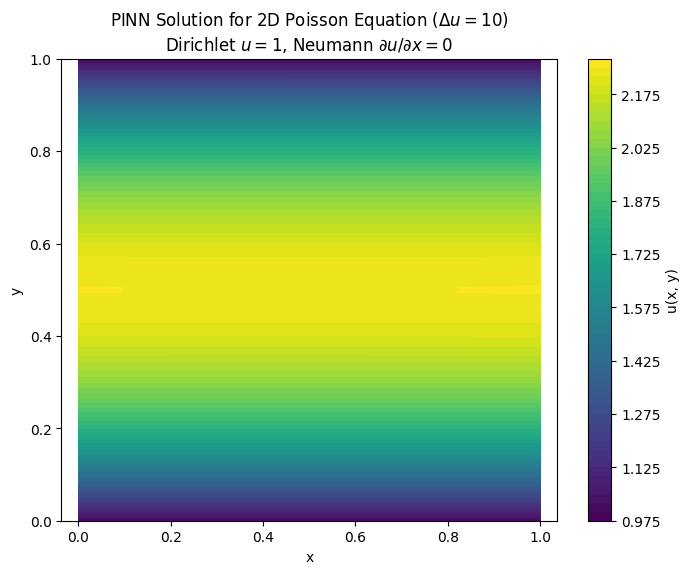

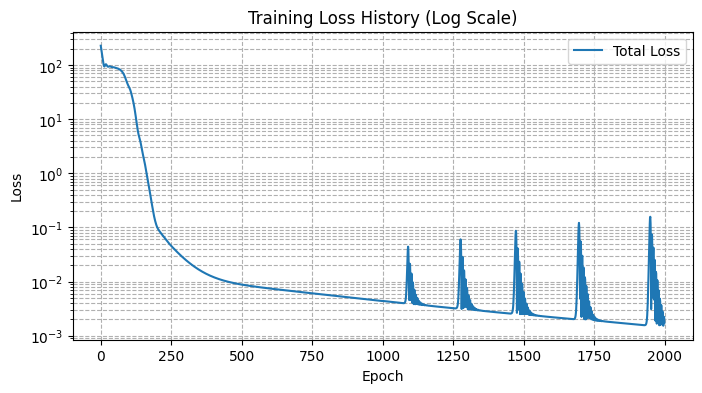

In [2]:
# --- 5. Visualization (Result Plot) ---

# Create a grid for prediction
N_plot = 100
x = np.linspace(0, 1, N_plot)
y = np.linspace(0, 1, N_plot)
X, Y = np.meshgrid(x, y)
xy_plot = np.vstack([X.flatten(), Y.flatten()]).T
xy_plot_tensor = torch.tensor(xy_plot, dtype=torch.float32).to(device)

# Predict the solution
model.eval()
with torch.no_grad():
    u_pred = model(xy_plot_tensor).cpu().numpy().flatten()
    
U_pred = u_pred.reshape(N_plot, N_plot)
print(max(u_pred))

# Plotting the solution
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, U_pred, levels=50, cmap='viridis')
plt.colorbar(contour, label='u(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'PINN Solution for 2D Poisson Equation ($\Delta u = 10$)\nDirichlet $u=1$, Neumann $\\partial u/\\partial x=0$')
plt.axis('equal')
plt.show()

# Plotting the loss history
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Total Loss')
plt.yscale('log')
plt.title('Training Loss History (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()